In [76]:
import numpy as np
import pandas
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.kernel_ridge import KernelRidge
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct
from sklearn.gaussian_process.kernels import RBF
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
#import statsmodels.api as sm
import pylab 
import itertools
#import UCB_new
from collections import defaultdict

%matplotlib inline

In [77]:
df = pandas.read_csv('trainset.rbs1.v2.csv', delimiter=',')

In [78]:
df.head()

,Construct,Barcode,rbs1_1_A,rbs1_1_C,rbs1_1_G,rbs1_1_T,rbs1_2_A,rbs1_2_C,rbs1_2_G,rbs1_2_T,...,rbs2_3_A,rbs2_3_C,rbs2_3_G,rbs2_3_T,Group,ODind,ODhar,FC,rbs1,rbs2
0,RBS629,77DD32,0,0,1,0,0,0,1,0,...,0,0,1,0,Top,0.410,4.523,1.437982,GGG,GGG
1,RBS678,77DD39,0,0,1,0,0,0,1,0,...,0,0,1,0,Top,0.359,2.678,1.277175,GGG,GGG
2,RBS353,77DD18,0,0,1,0,0,0,1,0,...,0,0,1,0,Top,0.334,1.745,1.545141,GGC,GGG
3,RBS403,77DD20,0,0,1,0,0,0,1,0,...,1,0,0,0,Top,0.390,2.166,1.670098,GGC,GGA
4,RBS500,77DD24,0,0,1,0,0,0,1,0,...,0,1,0,0,Top,0.375,2.348,1.621230,GGC,GGC


### Independence test

In [79]:
# create rewards sampels from training set

rbs1 = df['rbs1']
rbs2 = df['rbs2']
rbs1_u = rbs1.unique()
rbs2_u = rbs2.unique()

rewards_dict = defaultdict(list) # keys: rbs1+rbs2 string; values: list of FCs 
sorted_rewards_dict = defaultdict(list) 
arms = [] # e.g. 'AACGTC'
arms_encoding = [] # e.g. '100010000100001000010100'

for i in rbs1_u:
    for j in rbs2_u:
        values = list(df.loc[df['rbs1'] == i].loc[df['rbs2'] ==j]['FC'])
        if len(values) > 0:
            rewards_dict[i+j] = values
            arms.append(i+j)
arms = sorted(arms)

for i in arms:
    encodings = ''.join(str(e) for e in list(df.loc[df['rbs1'] ==  i[:3]].loc[df['rbs2'] == i[3:]].iloc[0,2:26]))
    arms_encoding.append(encodings)
    sorted_rewards_dict[i] = rewards_dict[i]

In [80]:

def distance_arms(arm1, arm2):
    assert len(arm1) == len(arm2)
    distance = 0
    for idx in range(len(arm1)):
        if arm1[idx] != arm2[idx]:
            distance += 1
        
    return distance

def chisquare_arms(arm1, arm2):
    return chisquare(rewards_dict[arm1], rewards_dict[arm2])

def abs_diff(arm1, arm2):
    return np.abs(np.mean(rewards_dict[arm1]) - np.mean(rewards_dict[arm2]))

In [81]:
from scipy.stats import chisquare

distance_dict = {} # keys: (arm1, arm2), values: (distance of arms, chisquare of arms)
new_dict = defaultdict(list) # keys: distances, values: sequences of scores

distance_list = []
score_list = []

for i, arm_i in enumerate(arms):
    for j, arm_j in enumerate(arms):
        if j > i:
            distance = distance_arms(arm_i, arm_j)
            score = abs_diff(arm_i, arm_j)
            distance_dict[(arm_i, arm_j)] = (distance, score)
            new_dict[distance].append(score)
            distance_list.append(distance)
            score_list.append(score)

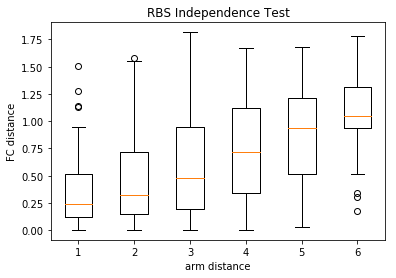

In [82]:
fig, ax = plt.subplots()

new_list = []

for key, value in new_dict.items():
    new_list.append(value)
ax.boxplot(new_list)

plt.title('RBS Independence Test')
plt.xlabel('arm distance')
plt.ylabel('FC distance')
plt.savefig('RBS_Independence_Test.png')

## GP-UCB

Viewing rbs1 and rbs2 as a string of length 6, each letter cound be one of the "A", "C", "G", "T", then there are totoally $4^6 = 4096$ choices (arms). However, for training dataset we only get 43 choices of rbs1 + rbs2.

So for this experiment, our assumption is we have 43 choices (arms), the distributions behind each arm is unknown but can be sampled from the sample set given from the training dataset (1 to 3 samples for each arm). The distributions are stored in a dictionary, with the string 'rbs1 + rbs2' as keys and a list of the sample rewards as values. Note the for each arm, the number of samples is different. Different samples are sampled with equal probablity (again, break the normal noise assumption here). The best arm is the arm with the highest average sample reward. We only initialise 10 arms randomly, otherwise we will know most of samples (considering that each arm only has one to three samples) before running the algorithm. 

We assume the arms are dependent (strings with small distance has big similarities), we use kernel to model the similarities (smoothness). 

Some choices of kernels are:

* linear kernel
* rbf 
* spectrum kernel (model sequences)

TODO: However, I think it's important to apply biology knoweledge into modelling, e.g. what is the relationship between "AAC" and "AAG"?

For now, let's use linear kernels to model GPs and illustrates an example. 

Issues: 

* we don't know the best actions! How do we evaluate regret?
* the reward distribution of each arm is a ratio and not gaussian (see qqplot above), which breaks our GP assumption. Can we convert?
* how to initialise? initalise once for each arm? I think it's ok to just random initially sample a subset, since we have too much arms (4096) and arms are dependent. 

Show: the objective, posterior mean and variance, acquisition function (maybe dynamic)

In [4]:
class GPUCB():
    """Perform GPUCB algorithm on environment
    
    Attributes
    --------------------------------
    
    environment: instance of DummyEnvironment, generate samples using x
    x, t: list of all index and values of samples
    maxlabel: max label of t
    beta: parameter for gaussian process
        beta can be fixed as specified by arguments
        beta also can be changed along with epoches
    alpha, mu, sigma: parameter for guassian process
    X, T: list of observed samples 
    cumu_regret: cumulative regret
    regret_list: list for regret for each epoch 
    """

    def __init__(self, env, arms, arms_encoding, num_rounds,
                 init_idx, alpha = 1., beta=1.):
        """
        Arguments
        ---------------------------------
        arms: list
            list of all arms (strings of len 6), e.g. 'AACTGC'
            sorted by alphabet order
        arms_encoding: list
            list of all arms one hot encodings (string of len 4 * 6),
            e.g. '100010000100000100100100'
            same order of 'arms'
        num_rounds: int
            number of rounds
        init_idx: list
            list of initial idx of arm (using the order of 'arms')
        alpha
            parameter for gaussian process 
        beta
            parameter for upper bound
        """

        self.env = env
        self.arms = arms
        self.arms_encoding = arms_encoding
        self.num_rounds = num_rounds
        self.init_idx = init_idx
        self.alpha = alpha
        self.beta = beta
        
        self.label = [self.env.sample_withoutnoise(arm) for arm in arms]
        self.bestarm_idx = np.argmax(self.label)
        self.X = []
        self.T = []
        self.cumu_regret = 0
        self.regret_list = []
        self.sample_idx = []

        
        self.mu = np.zeros_like(len(self.arms))
        self.sigma = 0.5 * np.ones_like(len(self.arms))
        # self.gp = GaussianProcessRegressor(alpha = self.alpha)
        self.gp = GaussianProcessRegressor(kernel=DotProduct())
        
    def to_list(self, arms):
        """encoding arms: from strings to one-hot encoding
        
        arm: str or list of str
            string for corresponding one hot encoding for rbs1 and rbs2
            e.g. '001000100010001000100010'
            
        Return: list or array
            e.g. [0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0]
        """
        
        if type(arms) is list:
            arms_encoding = np.zeros((len(arms), len(arms[0])))
            for i,arm in enumerate(arms):
                arms_encoding[i] = np.asarray([int(e) for e in list(arm)])
            return arms_encoding.astype(int) 
        else:
            return [int(e) for e in list(arms)]
        
    def to_string(self, code):
        """decoding arms: from one-hot encoding to strings
        
        code: list of one hot encoding
        
        Return: string
        """
        return ''.join(str(e) for e in code)   

    def argmax_ucb(self):
        """compute upper bound.
        """
        return np.argmax(self.mu + self.sigma * self.beta)

    def learn(self, epoch):
        """sample index with maximum upper bound and update gaussian process parameters
        """
        if len(self.X) > 0:   
            self.beta = 2.0 * np.log(len(self.X) * (epoch + 1.0))/20
        
        self.gp.fit(self.X, self.T)
        self.mu, self.sigma = self.gp.predict(self.arms_encoding, return_std=True)

        idx = self.argmax_ucb()
        self.sample(idx)
        self.regret(epoch)
        
    def play(self):
        """simulate n round games
        """
        self.init_reward(self.init_idx)
        for i in range(self.num_rounds):
            self.learn(i) 
            if i % 10 == 0:
                self.plot()

    def init_reward(self, init_idx):
        
        self.arms_encoding = self.to_list(self.arms_encoding)
        self.init_arms = self.arms_encoding[init_idx]
        for i, idx in enumerate(init_idx):
            self.X.append(self.init_arms[i])
            self.sample_idx.append(idx)
            self.T.append(self.env.sample(self.arms[idx]))

    def sample(self, idx):
        """sample idx according to the gound truth
        """
        
        self.X.append(self.arms_encoding[idx])
        self.sample_idx.append(idx)
        #print(self.X)
        self.T.append(self.env.sample(self.arms[idx]))
        
    def regret(self, t):
        if self.sample_idx[-1] != self.bestarm_idx:
            print('In ', t, 'iteration, selected: ', self.arms[self.sample_idx[-1]], ' best: ', self.arms[self.bestarm_idx])
            self.cumu_regret += self.env.sample(self.arms[self.bestarm_idx]) - self.T[-1]
        self.regret_list.append(self.cumu_regret)

    def plot(self):
        
        fig = plt.figure()
        ax = plt.axes()
        init_len = len(self.init_arms)

        #ax.scatter(self.mu, self.label, alpha=0.5, color='g', label = 'predict')
        #ax.fill_between(test_range, preds - pred_var, preds + pred_var, facecolor='k', alpha=0.2)

        ax.plot(range(len(self.mu)), self.mu, alpha=0.5, color='g', label = 'predict')
        ax.fill_between(range(len(self.mu)), self.mu + self.sigma, self.mu - self.sigma, facecolor='k', alpha=0.2)
        #init_len = len(self.x)
        ax.scatter(self.sample_idx[:init_len], self.T[:init_len], c='b', marker='o', alpha=1.0, label = 'init sample')
        ax.scatter(self.sample_idx[init_len:], self.T[init_len:], c='r', marker='o', alpha=1.0, label = 'selected sample')
        plt.legend()
        plt.xlabel('pred')
        plt.ylabel('true')
        plt.title('GPUCB')
        plt.show()

In [7]:
num_arms = len(rewards_dict.keys())

print('There are totoally', num_arms, 'unique combinations of rbs1 and rbs2.')

class rewards_env():
    def __init__(self, rewards_dict):
        self.rewards = rewards_dict
        
    def decoding(self, code):
        """decoding arms: from one-hot encoding to strings
        
        code: list of one hot encoding
        
        Return: string
        """
        return ''.join(str(e) for e in code)   
        
    def sample(self, idx):
        prob = np.random.uniform(0,1)
        idx = self.decoding(idx)
        my_range = np.arange(0, 1, 1.0/len(self.rewards[idx]))
    
        for i in range(len(my_range)):
            if i == len(my_range) - 1 and prob >= my_range[i]:
                return self.rewards[idx][i]
            elif prob >= my_range[i] and prob < my_range[i+1]:
                return self.rewards[idx][i]
            
    def sample_withoutnoise(self, idx):
        return np.mean(self.rewards[idx])
        

There are totoally 43 unique combinations of rbs1 and rbs2.


The xlabel is the arm distance, which is between 0 and 6, counting by the number of different letters of each pair of RBS. ylabel is FC distance, which is the absolute difference between each arms' corresponding FC score.
From the boxplot, we see the smaller the arm distance is, the smaller the FC distance is, which shows the RBS is relevant in terms of expressing FC.

In [7]:
num_exper = 1
num_round = 50
num_init = 10   
env = rewards_env(sorted_rewards_dict)

In  0 iteration, selected:  AGCGCC  best:  GAAAGA


/home/admin-u6015325/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:308: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


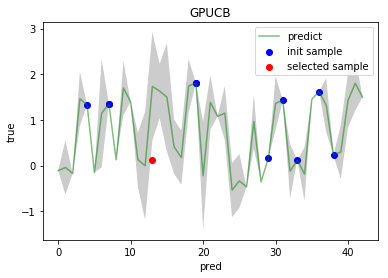

In  1 iteration, selected:  GGGGGC  best:  GAAAGA
In  2 iteration, selected:  GGCGGA  best:  GAAAGA
In  3 iteration, selected:  AAAGGA  best:  GAAAGA
In  4 iteration, selected:  GGCGGA  best:  GAAAGA
In  5 iteration, selected:  GGCGGA  best:  GAAAGA
In  6 iteration, selected:  AGGGGA  best:  GAAAGA
In  7 iteration, selected:  AGGGGA  best:  GAAAGA
In  8 iteration, selected:  GGCGGA  best:  GAAAGA
In  9 iteration, selected:  AAAGGA  best:  GAAAGA
In  10 iteration, selected:  GGCGGA  best:  GAAAGA


/home/admin-u6015325/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:308: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/admin-u6015325/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:308: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/admin-u6015325/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:308: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/admin-u6015325/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:308: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/admin-u6015325/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_proc

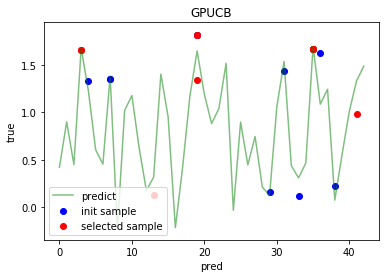

/home/admin-u6015325/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:308: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/admin-u6015325/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:308: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/admin-u6015325/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:308: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/admin-u6015325/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:308: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/admin-u6015325/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_proc

In  11 iteration, selected:  GGCGGA  best:  GAAAGA
In  12 iteration, selected:  GGCGGA  best:  GAAAGA
In  13 iteration, selected:  GGCGGA  best:  GAAAGA
In  14 iteration, selected:  GGCGGA  best:  GAAAGA
In  15 iteration, selected:  GGCGGA  best:  GAAAGA
In  16 iteration, selected:  GGCGGA  best:  GAAAGA
In  17 iteration, selected:  AAAGGA  best:  GAAAGA
In  18 iteration, selected:  GGCGGA  best:  GAAAGA
In  19 iteration, selected:  GGCGGA  best:  GAAAGA
In  20 iteration, selected:  GGCGGA  best:  GAAAGA


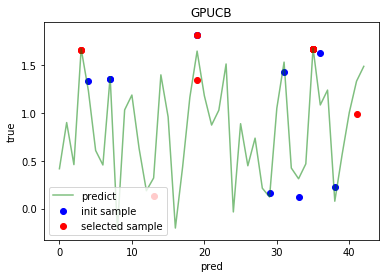

/home/admin-u6015325/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:308: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/admin-u6015325/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:308: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/admin-u6015325/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:308: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


In  21 iteration, selected:  GGCGGA  best:  GAAAGA
In  22 iteration, selected:  GGCGGA  best:  GAAAGA
In  23 iteration, selected:  GGCGGA  best:  GAAAGA
In  24 iteration, selected:  GGCGGA  best:  GAAAGA
In  25 iteration, selected:  GGCGGA  best:  GAAAGA
In  26 iteration, selected:  GGCGGA  best:  GAAAGA
In  27 iteration, selected:  GGCGGA  best:  GAAAGA
In  28 iteration, selected:  GGCGGA  best:  GAAAGA
In  29 iteration, selected:  GGCGGA  best:  GAAAGA
In  30 iteration, selected:  GGCGGA  best:  GAAAGA


/home/admin-u6015325/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:308: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/admin-u6015325/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:308: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/admin-u6015325/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:308: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/admin-u6015325/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:308: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


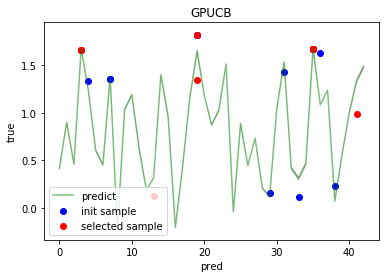

In  31 iteration, selected:  GGCGGA  best:  GAAAGA
In  32 iteration, selected:  GGCGGA  best:  GAAAGA
In  33 iteration, selected:  GGCGGA  best:  GAAAGA
In  34 iteration, selected:  AAAGGA  best:  GAAAGA


/home/admin-u6015325/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:308: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/admin-u6015325/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:308: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/admin-u6015325/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:308: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/admin-u6015325/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:308: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/admin-u6015325/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_proc

In  35 iteration, selected:  GGCGGA  best:  GAAAGA
In  36 iteration, selected:  GGCGGA  best:  GAAAGA
In  37 iteration, selected:  GGCGGA  best:  GAAAGA


/home/admin-u6015325/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:308: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/admin-u6015325/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:308: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/admin-u6015325/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:308: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


In  38 iteration, selected:  GGCGGA  best:  GAAAGA
In  39 iteration, selected:  GGCGGA  best:  GAAAGA
In  40 iteration, selected:  AAAGGA  best:  GAAAGA


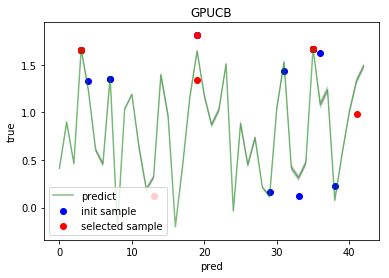

/home/admin-u6015325/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:308: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/admin-u6015325/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:308: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/admin-u6015325/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:308: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/admin-u6015325/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:308: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/admin-u6015325/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_proc

In  41 iteration, selected:  GGCGGA  best:  GAAAGA
In  42 iteration, selected:  AAAGGA  best:  GAAAGA
In  43 iteration, selected:  AAAGGA  best:  GAAAGA
In  44 iteration, selected:  GGCGGA  best:  GAAAGA
In  45 iteration, selected:  AAAGGA  best:  GAAAGA
In  46 iteration, selected:  GGCGGA  best:  GAAAGA
In  47 iteration, selected:  GGCGGA  best:  GAAAGA
In  48 iteration, selected:  GGCGGA  best:  GAAAGA
In  49 iteration, selected:  GGCGGA  best:  GAAAGA


/home/admin-u6015325/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:308: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/admin-u6015325/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:308: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/admin-u6015325/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:308: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


In [8]:
regrets = []
for e in range(num_exper):
    init_list = np.random.randint(0,len(arms),num_init)
    gpucb = GPUCB(env, arms, arms_encoding, num_round, init_list)
    gpucb.play()
    regrets.append(gpucb.regret_list)

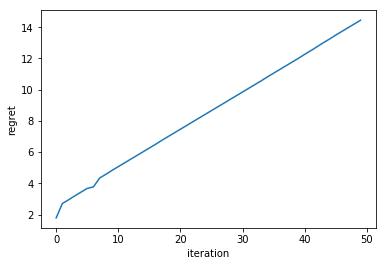

In [9]:
regrets = np.asarray(regrets).reshape((num_exper, num_round))
ave_regrets = np.mean(regrets, axis = 0)
plt.xlabel('iteration')
plt.ylabel('regret')
plt.plot(range(len(ave_regrets)), ave_regrets)